In [1]:
# Import libraries to get gold price from investing.com
import investpy
import datetime

In [2]:
# Check the current day and reformat to  dd/mm/yyyy
t=datetime.date.today()
today=t.strftime("%d/%m/%Y")
print(today)

06/06/2022


In [3]:
# Get gold price from investing.com, name index to Date
df=investpy.commodities.get_commodity_historical_data(commodity='gold',from_date='01/08/2020',to_date=today)
df

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-08-03,1979.70,1992.10,1958.50,1969.50,2824,USD
2020-08-04,1976.60,2020.50,1968.10,2004.20,3913,USD
2020-08-05,2020.20,2053.50,2011.20,2032.90,4751,USD
2020-08-06,2036.90,2065.10,2033.60,2054.60,2610,USD
2020-08-07,2062.40,2074.00,2011.00,2014.30,4374,USD
...,...,...,...,...,...,...
2022-06-01,1840.00,1853.00,1830.20,1848.70,158036,USD
2022-06-02,1849.90,1874.40,1846.50,1871.40,127471,USD
2022-06-03,1872.60,1878.60,1849.70,1850.20,115343,USD


In [4]:
# Cleaning Data
del df['Volume']
del df['Currency']
# Cleaning Empty Cells
df.dropna(inplace=True)
# Cleaning Data of Wrong Format
# Cleaning Wrong Data
for x in df.index:
    if df.loc[x,'Open']==0:
        df.drop(x,inplace=True)
print(df)

               Open     High      Low    Close
Date                                          
2020-08-03  1979.70  1992.10  1958.50  1969.50
2020-08-04  1976.60  2020.50  1968.10  2004.20
2020-08-05  2020.20  2053.50  2011.20  2032.90
2020-08-06  2036.90  2065.10  2033.60  2054.60
2020-08-07  2062.40  2074.00  2011.00  2014.30
...             ...      ...      ...      ...
2022-06-01  1840.00  1853.00  1830.20  1848.70
2022-06-02  1849.90  1874.40  1846.50  1871.40
2022-06-03  1872.60  1878.60  1849.70  1850.20
2022-06-05  1853.40  1856.15  1852.85  1854.00
2022-06-06  1854.25  1858.75  1853.10  1858.05

[488 rows x 4 columns]


In [5]:
# Check if index is Date or not?
print(type(df.index))
# Check if data type of every columns are Float
print(df.dtypes)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Open     float64
High     float64
Low      float64
Close    float64
dtype: object


In [6]:
# Import libraries to build ARIMA model
import pandas as pd
import numpy as np
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Automate the augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

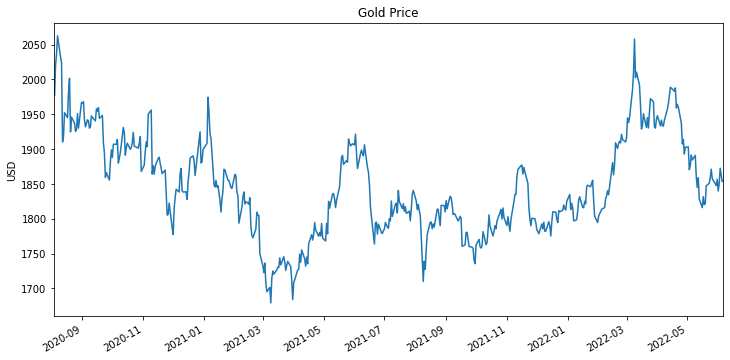

In [8]:
# Plot the Source Data
ax=df['Open'].plot(figsize=(12,6),title='Gold Price')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel='',ylabel='USD');

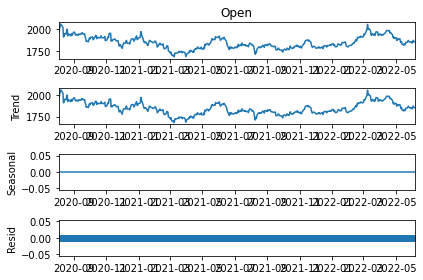

In [9]:
# Run an ETS Decomposition (Error-Trend-Seasonality Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['Open'],model='addictive',period=1)
result.plot();
#Observed-Trend-Seasonal-Residual

In [10]:
# Use pmdarima.auto_arima to determine ARIMA Orders
auto_arima(df['Open'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  488
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2129.040
Date:                Mon, 06 Jun 2022   AIC                           4264.081
Time:                        11:13:00   BIC                           4276.645
Sample:                             0   HQIC                          4269.017
                                - 488                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7638      0.132      5.783      0.000       0.505       1.023
ma.L1         -0.8436      0.110     -7.649      0.000      -1.060      -0.627
sigma2       367.0523     12.835     28.597      0.000     341.896     392.209
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               531.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Run the augmented Dickey-Fuller Test on the First Difference
from statsmodels.tsa.statespace.tools import diff
df['1std']=diff(df['Open'],k_diff=1)
adf_test(df['1std'],'Gold Price Prediction')

Augmented Dickey-Fuller Test: Gold Price Prediction
ADF test statistic      -23.530868
p-value                   0.000000
# lags used               0.000000
# observations          486.000000
critical value (1%)      -3.443877
critical value (5%)      -2.867505
critical value (10%)     -2.569947
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


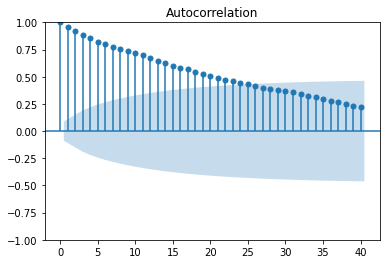

In [12]:
# Run the ACF plot
plot_acf(df['Open'],title='Autocorrelation',lags=40);

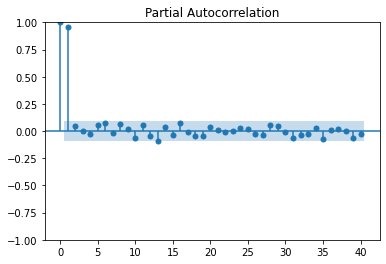

In [13]:
# Run the PACF plot
plot_pacf(df['Open'],title='Partial Autocorrelation',lags=40);

In [14]:
# Use pmdarima.auto_arima done stepwise to see if the previous p and q terms still makes sense
stepwise_fit=auto_arima(df['Open'],start_p=0,start_q=0,max_p=2,max_q=2,m=7,seasonal=False,d=None,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4269.406, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4269.208, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4268.950, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4267.492, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4265.863, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4267.863, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4267.863, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4269.286, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4269.751, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4269.389, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4264.081, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4267.052, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4267.307, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4266.081, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  488
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2129.040
Date:                Mon, 06 Jun 2022   AIC                           4264.081
Time:                        11:13:12   BIC                           4276.645
Sample:                             0   HQIC                          4269.017
                                - 488                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7638      0.132      5.783      0.000       0.505       1.023
ma.L1         -0.8436      0.110     -7.649      0.000      -1.060      -0.627
sigma2       367.0523     12.835     28.597      0.000     341.896     392.209
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               531.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Split the data into train/test sets
train,test=df[df.index<'30/05/2022'],df[df.index>='30/05/2022']

In [16]:
# Fit an ARIMA(1,1,1) Model
model=ARIMA(train.Open,order=(1,1,1))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  481
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2100.249
Date:                Mon, 06 Jun 2022   AIC                           4206.497
Time:                        11:13:16   BIC                           4219.019
Sample:                             0   HQIC                          4211.419
                                - 481                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7705      0.133      5.805      0.000       0.510       1.031
ma.L1         -0.8481      0.111     -7.653      0.000      -1.065      -0.631
sigma2       369.8403     13.035     28.373      0.000     344.293     395.388
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               521.47
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

In [18]:
# Reindex predictions to the right datetime Series
predictions=pd.DataFrame(predictions)
predictions.index=test.index
print(predictions,type(predictions.index))

            ARIMA(1,1,1) Predictions
Date                                
2022-05-30               1850.881043
2022-05-31               1851.136106
2022-06-01               1851.332627
2022-06-02               1851.484043
2022-06-03               1851.600707
2022-06-05               1851.690594
2022-06-06               1851.759850 <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [19]:
# Create new DataFrame by reset_index() to avoid error when compare predictions to expected values
newtest=test.reset_index(drop=True)
#print(newtest)
newpredictions=predictions.reset_index(drop=True)
#print(newpredictions)

In [20]:
# Compare predictions to expected values
for x in range(len(predictions)):
    print(f"predicted={newpredictions['ARIMA(1,1,1) Predictions'].loc[x]:11.10}"",",f"expected={newtest['Open'].loc[x]}")

predicted=1850.881043, expected=1847.79
predicted=1851.136106, expected=1856.5
predicted=1851.332627, expected=1840.0
predicted=1851.484043, expected=1849.9
predicted=1851.600707, expected=1872.6
predicted=1851.690594, expected=1853.4
predicted= 1851.75985, expected=1854.25


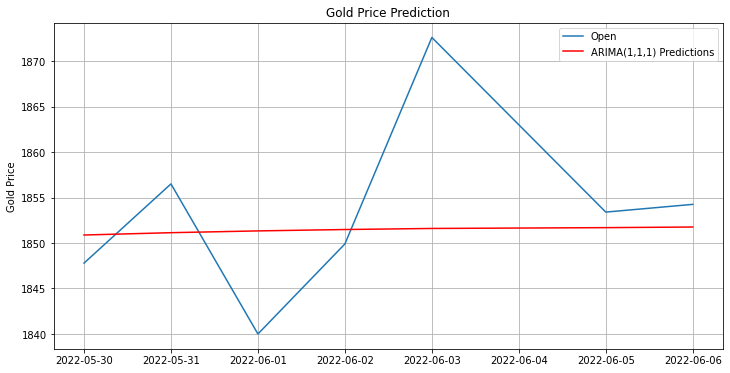

In [21]:
# Plot predictions against known values
import matplotlib.pyplot as plt
Open=pd.DataFrame(df['Open'])
plt.figure(figsize=(12,6))
plt.plot(test.Open)
plt.plot(predictions,color='red')
plt.ylabel("Gold Price")
plt.title("Gold Price Prediction")
plt.grid()
plt.legend(["Open","ARIMA(1,1,1) Predictions"])
plt.show()

In [22]:
# Evaluate the Model
from sklearn.metrics import mean_squared_error
import math
MSE=mean_squared_error(test['Open'],predictions)
print(f"ARIMA(1,1,1) MSE:",MSE)
RMSE=math.sqrt(MSE)
print(f"ARIMA(1,1,1) RMSE:",RMSE)

ARIMA(1,1,1) MSE: 88.47954040040278
ARIMA(1,1,1) RMSE: 9.40635638280853


In [23]:
# Retrain the model on the full data
model = ARIMA(df['Open'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df),len(df)+5,typ='levels').rename('ARIMA(1,1,1) Forecast')

In [24]:
# Get date for 5 following days to reindex fcast
s=datetime.date(2020,8,1)
e=datetime.date(2022,6,6)
dura=e-s
dura=dura.days
#print(dura,dura-len(df))
dura_fcast=datetime.timedelta(days=5)
#print(dura_fcast)
start_fcast=e
end_fcast=start_fcast+dura_fcast
#create arr_date
arr_date = []
#print(start_fcast,end_fcast)
for i in range (6):
    period=datetime.timedelta(days=i)
    if (start_fcast+period)<=end_fcast:
        #print(start_fcast+period)
        arr_date.append(start_fcast+period)

In [25]:
# Reindex fcast to the right datetime
fcast=pd.DataFrame(fcast)
#print(fcast)
index_fcast=pd.DataFrame(data={"Date": arr_date},index=fcast.index)
#print(fcast)
fcast.index = index_fcast["Date"]
print(fcast,type(fcast.index))

            ARIMA(1,1,1) Forecast
Date                             
2022-06-06            1854.256833
2022-06-07            1854.262052
2022-06-08            1854.266039
2022-06-09            1854.269083
2022-06-10            1854.271409
2022-06-11            1854.273185 <class 'pandas.core.indexes.base.Index'>


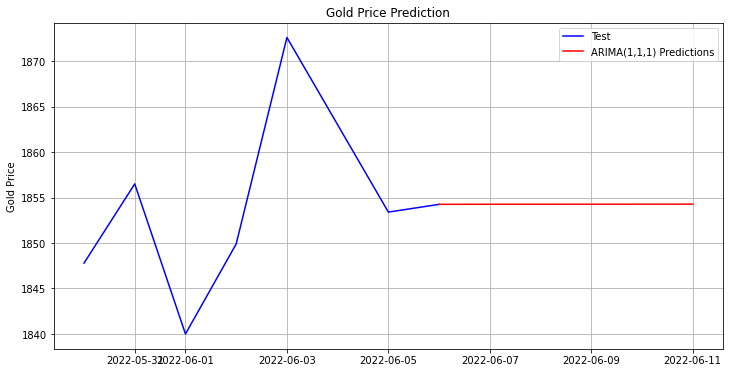

In [26]:
# Forecast the future
Open=pd.DataFrame(df['Open'])
plt.figure(figsize=(12,6))
#plt.plot(Open)
plt.plot(test.Open, color= "blue")
plt.plot(fcast,color='red',label = 'predict')
plt.ylabel("Gold Price")
plt.title("Gold Price Prediction")
plt.grid()
#plt.legend(["DF","Test","ARIMA(1,1,1) Predictions"])
plt.legend(["Test","ARIMA(1,1,1) Predictions"])
plt.show()
